In [ ]:
# imports
import cv2  # for image handeling stuff
import numpy as np  # for matrix operations & cv2
from matplotlib import pyplot as plt  # for plotting
from matplotlib.pyplot import imshow  # cause i'm lazy to write plt.

# from tqdm import tqdm
import math  # math related tasks
from bresenham import bresenham as line_iter  # generates point along a line


In [ ]:
def create_circular_mask(h, w, center=None, radius=None):
    """
    Creates a circular mask for an image of given height and width.

    Parameters:
    h (int): Height of the image.
    w (int): Width of the image.
    center (tuple, optional): The (x, y) coordinates of the circle's center. Defaults to the center of the image.
    radius (int, optional): The radius of the circle. Defaults to the smallest distance from the center to the image edges.

    Returns:
    numpy.ndarray: A boolean mask with the same dimensions as the input image, where True values represent the inside of the circle.
    """

    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    mask = dist_from_center <= radius
    return mask


110.575532


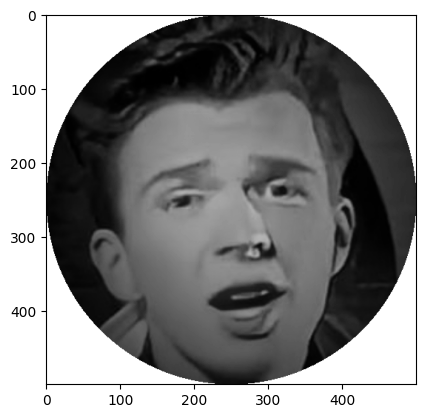

In [ ]:
# load, resize & grayscaling the image
img = cv2.imread("../radon transform/rick_vigq.png")
img = cv2.resize(img, (500, 500))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# in orig i save the original image for later use
orig = img.copy()
mask = create_circular_mask(orig.shape[0], orig.shape[1])
orig[~mask] = 255

# stopping point is some kind of threshold where to stop
# when the canvas image has "leve" of overall brightness
stopping_point = np.mean(orig)
print(stopping_point)

# canvas - a image where i draw the lines
canvas = np.full_like(img, 255)
canvas[0, 0] = 0
canvas[0, 1] = 255

imshow(orig, cmap="gray")


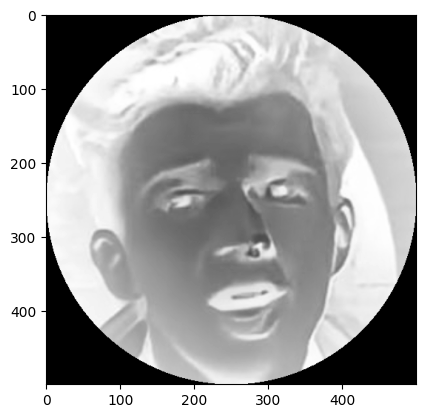

In [ ]:
# the image
imgcircle = img.copy()
# i mask the image out
imgcircle[~mask] = 255
# and invert it
# that's because I draw with black lines onto a white plane
# so the most black region becomes the most white, with max value
imginverted = np.full(img.shape, 255) - imgcircle

img = imginverted

imshow(img, cmap="gray")


In [ ]:
def generate_circle_points(center, radius, n):
    """
    Generate points on the circumference of a circle.

    Parameters:
    center (tuple): A tuple (x, y) representing the coordinates of the circle's center.
    radius (float): The radius of the circle.
    n (int): The number of points to generate on the circle's circumference.

    Returns:
    list: A list of tuples, where each tuple represents the (x, y) coordinates of a point on the circle's circumference.
    """
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    points = [
        (center[0] + radius * np.cos(angle), center[1] + radius * np.sin(angle))
        for angle in angles
    ]
    return points


center = (img.shape[0] // 2, img.shape[1] // 2)
radius = min(img.shape) // 2 - 5
# number of point
n = 300
# these are basically the nails around
circle_points = generate_circle_points(center, radius, n)

img_gray = np.full_like(img, 0, dtype=np.uint8)
for point in circle_points:
    img_gray[int(point[1]), int(point[0])] = 255
    cv2.line(
        img_gray, (int(point[1]), int(point[0])), (int(point[1]), int(point[0])), 255, 1
    )

# imshow(img_gray, cmap="gray")

# array for the nails to be wrapped around
spagat = [0]


In [ ]:
while True:
    # i get the last nail, where the string ends
    from_pos = circle_points[spagat[-1]]
    # this is a structure for the best nail that i could find
    # first value is which nail is currentlly best, second is the best found value
    best = [-1, -math.inf]

    # i iterate over all of the other nails
    for indx, to_pos in enumerate(circle_points):
        if indx == spagat[-1]:
            continue

        # i iterate over the line that i may draw, and i save all the points on the line
        lajna = []
        for x, y in line_iter(
            int(from_pos[0]), int(from_pos[1]), int(to_pos[0]), int(to_pos[1])
        ):
            lajna.append(img[y, x])

        lajna = np.array(lajna)
        # how much of a "correct" gray would I add
        prekryv = np.sum(lajna)

        # and if I would add more, i update the best
        if prekryv > best[1]:
            best = [indx, prekryv]
            bst = (from_pos, to_pos)
            best_lajna = lajna

    # I draw the best line onto a image
    canvas_w_line = cv2.line(
        np.full_like(canvas, 0),
        tuple(map(int, from_pos)),
        tuple(map(int, circle_points[best[0]])),
        255,
        1,
    )

    # which i then draw to the canvas (where I keep all the lines)
    canvas = cv2.subtract(canvas, canvas_w_line)
    # and also from the image that I use to keep track of where i need to add lines
    img = cv2.subtract(img, canvas_w_line, dtype=cv2.CV_8U)

    # i append the nail to the spagat
    spagat.append(best[0])

    print(np.mean(canvas))
    # and when i reach the stopping point, I stop
    if np.mean(canvas) < stopping_point:
        break


254.49918
254.01162
253.51896
253.0416
252.58362
252.10728
251.68194
251.27598
250.92408
250.52628
250.1754
249.79698
249.40326
249.033
248.6658
248.31084
247.93038
247.47036
247.00932
246.53706
246.06174
245.61294
245.17434
244.72044
244.2747
243.81366
243.35364
242.9283
242.45808
242.00418
241.58394
241.19022
240.7455
240.29976
239.91012
239.5827
239.24916
238.87074
238.51272
238.11288
237.7518
237.42744
237.08778
236.6553
236.2218
235.78218
235.3242
234.9009
234.51534
234.14814
233.83602
233.40864
232.9578
232.52226
232.09284
231.66138
231.21564
230.80254
230.36394
229.9131
229.46736
229.0359
228.58608
228.15054
227.81088
227.47632
227.04894
226.63788
226.20642
225.80556
225.35268
224.9508
224.52954
224.10318
223.68294
223.278
222.9057
222.4875
222.06216
221.65722
221.23494
220.84632
220.47606
220.0548
219.64374
219.2286
218.89914
218.60232
218.2749
217.872
217.47216
217.09986
216.72042
216.3165
215.91972
215.51784
215.14044
214.73448
214.34178
213.9603
213.59922
213.30852
213.00966

110.53536


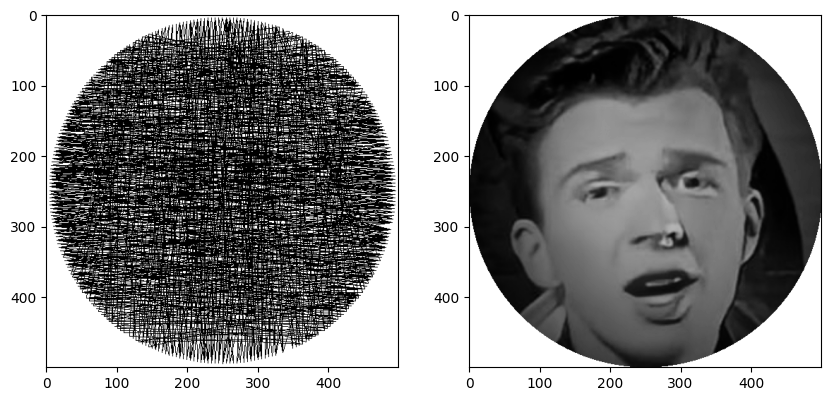

In [ ]:
print(np.mean(canvas))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(
    canvas,
    cmap="gray",
)
plt.subplot(1, 2, 2)
imshow(orig, cmap="gray")
